<h1><center>Discovering Manchester</center></h1>
<h2><center>Part 3: Data Preprocessing</center></h2>


<h4><center> IBM Capstone Project - Exploring the best areas for a young professional to move to in Greater Manchester </center></h4>

## Libraries

In [1]:
# data structures
import pandas as pd
import geopandas as gpd

# easy plotting
import matplotlib.pyplot as plt

# for weights matrix
# from libpysal import weights

# Feature scaling
from sklearn.preprocessing import MinMaxScaler

# Models
# from sklearn.cluster import KMeans
# from sklearn.cluster import AgglomerativeClustering

# # Maps
# import folium
# from folium.plugins import MarkerCluster
# from folium import GeoJsonTooltip
# import branca

## Load Data

In [2]:
geodf = gpd.read_file('mcr_geo_green.json')
mcr_venues = pd.read_csv('manchester_venues.csv')

Although the data has been extracted in the previous parts of this project, some preproccessing is still necessary.

Some observations are made on the imported datasets below.

In [3]:
geodf.columns

Index(['NAME', 'AREA_CODE', 'DESCRIPTIO', 'FILE_NAME', 'NUMBER', 'NUMBER0',
       'POLYGON_ID', 'UNIT_ID', 'CODE', 'HECTARES', 'AREA', 'TYPE_CODE',
       'DESCRIPT0', 'TYPE_COD0', 'DESCRIPT1', 'lat', 'lng', 'Greenspace',
       'Greenspace(pct)', 'geometry'],
      dtype='object')

The particularly relevant columns here are NAME, 'Greenspace(pct)' and geometry.

NAME is simply the name of the ward.

Greenspace(pct) is the proportion of the ward which is classified as greenspace (boxplot shown below). This will be used as a feature for the clustering.

geometry is the Shapefile of the wards, and contains the geographical information required for mapping the polygons as well as determining the geospatial relationships between the ward. While the geometry column is clearly very important, no work is required to be done directly on this series and it is handeled by the relevant libraries (this is covered in the following sections in more detail where relevant).

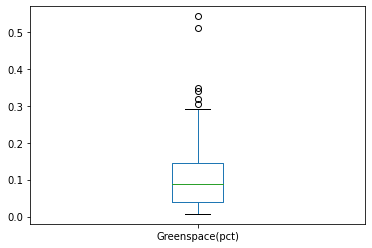

In [11]:
geodf['Greenspace(pct)'].plot.box();

In [4]:
mcr_venues.columns

Index(['Neighbourhood', 'Arts & Entertainment', 'Food', 'Nightlife Spot',
       'Outdoors & Recreation', 'Shop & Service', 'Travel & Transport'],
      dtype='object')

The mcr_venues dataframe contains the name of the wards in the 'Neighbourhood' column. The remaining columns contain counts of venues in that category for each ward. The distributions of the venue counts are shown in the boxplots below.

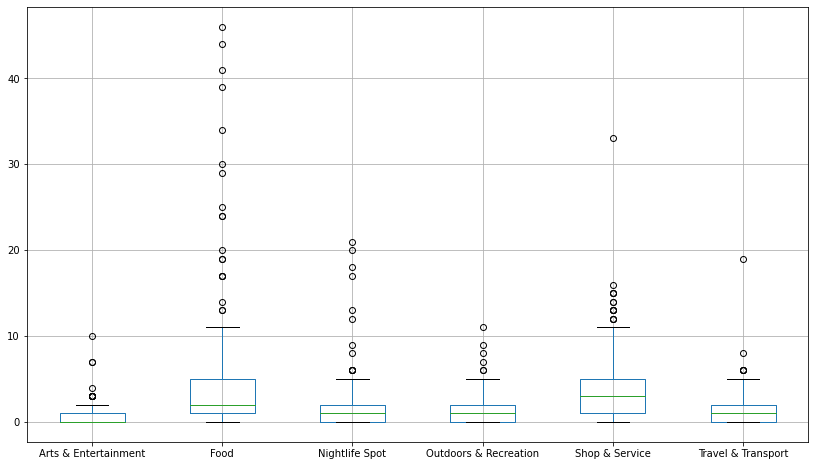

In [5]:
mcr_venues.boxplot(figsize=(14,8));

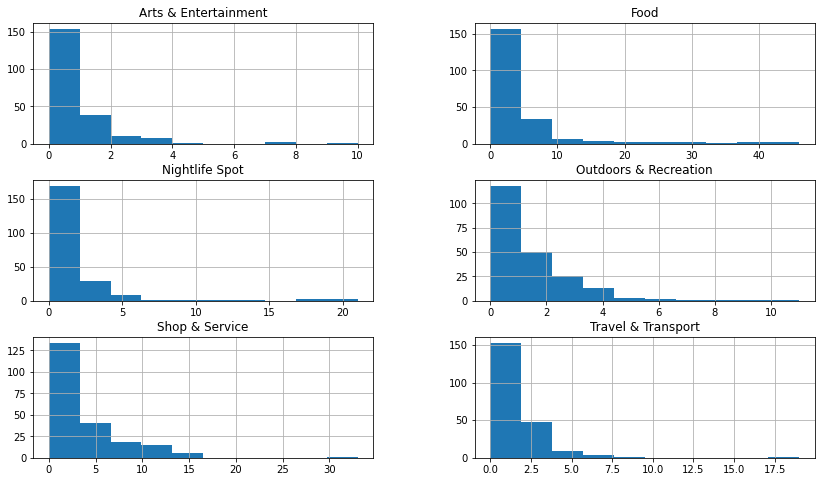

In [6]:
mcr_venues.hist(figsize=(14,8));

As can be clearly seen above, the venue counts are all positively skewed with several postive outliers and of various ranges. From the histograms also shown, and the knowledge that we are dealing with discrete count values, the data resembles a poisson distribution.

As shown in the boxplot from the 'Greenspace(pct)' values, the range of values present across the features varies greatly, meaning some form of standarising is a necessity.

While standardising continuous data (i.e. for Greenspace) is relatively straightforward, count data and poisson distributions, particularly those that are zero inflated, are notoriously difficult for standardising. While there are numerous statisticaly complex approaches to standardising zero-inflated two simple methods are approached below.

## Feature Selection and Optimisation

Here the features that will be used for clustering are extracted. 

For the venue counts, two sets of features are saved; a log<sub>10</sub>(x+1) transformed set and an untransformed set. Sklearn's MinMaxScaler is applied to both sets along with the Greenspace(pct) to allow all features to be of the same range.

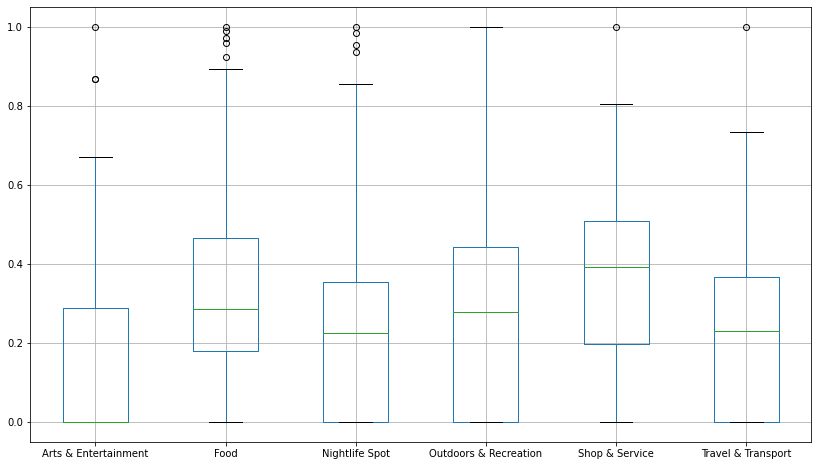

In [22]:
# log 10 transformed values

import numpy as np
venue_info_log = mcr_venues.drop("Neighbourhood", axis=1)

mcr_venues_log_scaled = pd.concat([mcr_venues.Neighbourhood,pd.DataFrame(
    MinMaxScaler().fit_transform(
        venue_info_log.transform(lambda x: np.log(x+1))))],axis=1)

# Rename Neighbourhood to NAME for matching with geodf
mcr_venues_log_scaled.columns=mcr_venues.columns
mcr_venues_log_scaled = mcr_venues_log_scaled.rename(columns = {'Neighbourhood':'NAME'})

# plot histogram of scaled food venues
mcr_venues_log_scaled.boxplot(figsize=(14,8));

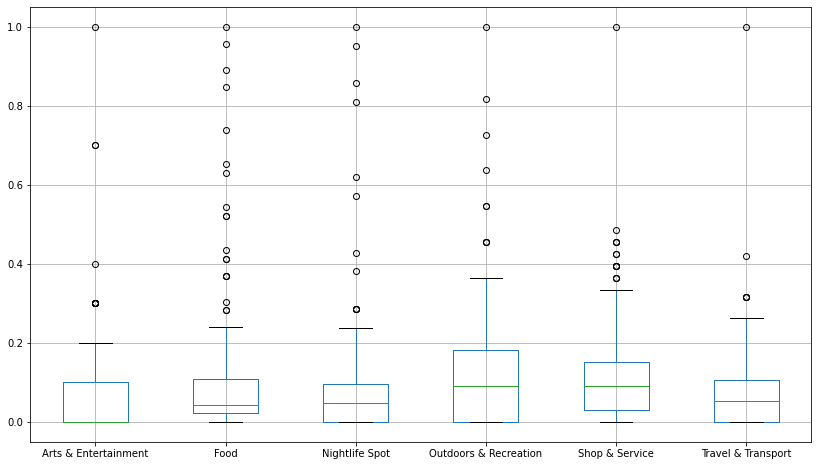

In [8]:
venue_info = mcr_venues.drop("Neighbourhood", axis=1)

mcr_venues_scaled = pd.concat([mcr_venues.Neighbourhood,pd.DataFrame(
                    MinMaxScaler().fit_transform(venue_info))],axis=1)

# Rename Neighbourhood to NAME for matching with geodf
mcr_venues_scaled.columns=mcr_venues.columns
mcr_venues_scaled = mcr_venues_scaled.rename(columns = {'Neighbourhood':'NAME'})

# plot histogram of scaled food venues
mcr_venues_scaled.boxplot(figsize=(14,8));

From the first boxplot (log<sub>10</sub> transormed data), there is a significant reduction in outliers. While the skewness of the data are still present in the untransformed data, it remains to be seen which method will give better results when clustered. Both sets of scaled venue counts are now within the range [0,1].

The greenspace column from geodf must also be similarly scaled. 

Finally, the greenspace and venue data (log transformed and untransformed) are merged and saved to csv files for clustering.

In [14]:
# Scale greenspace values
geodf['Greenspace_scaled'] = pd.DataFrame(MinMaxScaler().fit_transform(geodf['Greenspace(pct)'].values.reshape(-1,1)))

# Create feature sets.
features = mcr_venues_scaled.merge(geodf[['NAME','Greenspace_scaled']], how='right', on = 'NAME').drop('NAME', axis=1)
features.to_csv('features.csv',index=False)

features_log = mcr_venues_log_scaled.merge(geodf[['NAME','Greenspace_scaled']], how='right', on = 'NAME').drop('NAME', axis=1)
features_log.to_csv('features_log.csv',index=False)